In [1]:
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import LocalOutlierFactor

from category_encoders import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Helpers

In [104]:
def make_clusters(df, col, y, n_cluster, merge=False):
    '''
        function to boil down a colum to n_cluster
        
        recive:
        
            df: a data frame 
            col: col to make cluster
            y: the response variable
            n_cluster: stamitation of number of cluster
            
        return:  
            a data frame with 'col' droped, and 'col' + '_cluster' column
            is added to the data frame

        
    '''
    col_clusters = KMeans(n_clusters=n_cluster, random_state=777)

    # 'Neighborhood' and 'MSSubClass' stats
    col_stats = df.groupby(col)[y].describe()

    # Getting clusters
    col_clusters.fit(col_stats)

    # preparing DF with cluster lables to merge
    new_name = col + '_Cluster'
    col_cluster_df = pd.DataFrame( { col: col_stats.index.to_list(),
                                     new_name: col_clusters.labels_.tolist()} )
    
    if merge:
        # merging the clusters with the data frame
        df = df.merge(col_cluster_df, how='left', on=col)

        df[new_name] = df[new_name].astype(str)
        
        result = df.drop(columns=col)
        
    else:
        result = col_cluster_df
    
    return result.copy()


# Low frequency categories to 'Other'
def lower_than(df, col, percentage):
    ''' function that will merge low frequency classes into 
        a single class 'Others'

        parameters:
            df: a DataFrame
            col: column's name to work on
            percentage(%): the threshold like 0.1, 0.2

        returns:
            df: the data frame with col's classes that are lowers
                than 'threshold' been repleced with 'Other' category
    '''

    # calculating the column frequency
    col_freq = df[col].value_counts(normalize=True)

    # the getting the column threshold 
    threshold = col_freq.quantile(q= percentage)

    # knowing the classes that are below the threshold
    less_freq_classes = col_freq[ col_freq <= threshold ]

    others = less_freq_classes.index.to_list()

    print(others)

    df[col] = df[col].replace(others, 'Others')

    return df


### Data

In [20]:
def data(verbose=False):
    
    d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/train.csv', index_col='Id')
    d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/test.csv', index_col='Id')
    
    # Utilities has just 2 categories, and one of them
    # just appears once so we delete the whole column.
    d_tr = d_tr.drop(columns='Utilities')
    d_te = d_te.drop(columns='Utilities')
    
    # Marking Training Set
    d_tr['Training'] = True
    d_te['Training'] = False  
    
    if(verbose):
        print('d_tr shape:', d_tr.shape)
        print('d_te shape:', d_te.shape)
        
    return (d_tr.copy(), d_te.copy())
    

### Analazy 'Y'('SalePrice')

In [78]:
def analyze_y(df, verbose=False):
    
    
    df = df.copy()
    
    # Plotting
    if(verbose):
        fg, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(11,7))
        # chequing the distribution of 'y' = 'SalePrice'
        
        sns.histplot( df['SalePrice'], bins=50, ax= ax1);
        ax1.title.set_text('Skewed SalePrice')
    
        sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], ax=ax3);
        ax3.title.set_text('Outliers')
    
    outliers = df[ df['GrLivArea'] >= 4500].index
    
    # deleting the outliers in 'GrLivArea'
    df.drop(outliers, inplace=True)
    
    # Plotting
    if(verbose):
        # cheking again
        sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], ax=ax4);
        ax4.title.set_text('NO Outliers')
    
    # pipeline to scale and do a powerTransforme on y('SalePrice')
    fix_y = Pipeline([('scaler', RobustScaler()), ('power', PowerTransformer(method='yeo-johnson'))])
    
    y = fix_y.fit_transform( df['SalePrice'].values.reshape(-1, 1) )
    
    # Plotting
    if(verbose):
        # checking the distribution of 'y' again
        sns.histplot(y, bins=50, ax=ax2);
        ax2.title.set_text('yeo-johnson transformed \'y\'')
        
        plt.tight_layout()
        plt.show()
        
    df['SalePrice'] = y.copy()
    
    return df.copy()
    

### Combining training and test sets

In [86]:
def combine_tr_te(df_tr, df_te, verbose=False):
    
    all_d = pd.concat([d_tr.copy(), d_te.copy()])
    
    if(verbose):
        print('New data shape: ', all_d.shape)
        
    return all_d.copy()

### Imputting 'nan'

In [88]:

def impute_nan(all_data):
    
    # 34 columns with nan
    def fillWithNone(df):
        ''' nan in 'PoolQC' means 'no pool' 
            nan in 'MiscFeature' means 'no misc feature'
            nan in 'Alley' means 'no alley acces'
            nan in 'Fence' means 'no fence'
            nan in 'FireplaceQu' means 'no Fireplace'
            nan in 'GarageType', 'GarageFinish', 'GarageQual',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
                'BsmtFinType1', 'MasVnrType', 'MSSubClass'
                'GarageCond' replaced with 'None' too

            recive a df
        '''

        df = df.copy()

        columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
                   'FireplaceQu', 'GarageType', 'GarageFinish', 
                   'GarageQual', 'GarageCond', 'BsmtQual',
                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'MasVnrType'
                  ]

        for col in columns:
            df[col] = df[col].fillna('None')

        return df

    def fillWithZero(df):
        ''' nan 

        '''

        df = df.copy()

        columns = ['GarageYrBlt', 'GarageArea', 'GarageCars',
                   'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                   'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                   'MasVnrArea'
                  ]

        for col in columns:
            df[col] = df[col].fillna(0)

        return df

    def fillWithMode(df):
        ''' fill missing values with mode, median
        '''
        df = df.copy()

        columns = ['Electrical', 'KitchenQual', 'Exterior1st',
                   'Exterior2nd', 'SaleType'
                  ]

        for col in columns:
            df[col] = df[col].fillna(df[col].mode()[0])

        # filling with median of each 'Neighborhood'
        df['LotFrontage'] = (
                         df.groupby('Neighborhood')['LotFrontage']
                         .transform(lambda x: x.fillna(x.median()))
                        )  

        # nan means Typical
        df['Functional'] = df['Functional'].fillna('Typ')

        return df


    def mszoning(df):
        ''' recives a DF this imputation takes place on test data only'''

        df = df.copy()

        idotrr = ( (df['Neighborhood'] == 'IDOTRR') & (df['MSZoning'].isna()) )
        mitchel = ( (df['Neighborhood'] == 'Mitchel') & (df['MSZoning'].isna()) )

        df.loc[ idotrr , 'MSZoning'] = 'RM'
        df.loc[ mitchel, 'MSZoning'] = 'RL'

    #     # to test this function out of here
    #     temp = mszoning(d_te)
    #     # lable index acces at [1916, 2217, 2251, 2905
    #     temp.loc[[1916, 2217, 2251, 2905], 'MSZoning']

        return df

    none_func = FunctionTransformer(fillWithNone, validate=False) 
    zero_func = FunctionTransformer(fillWithZero, validate=False) 
    mode_func = FunctionTransformer(fillWithMode, validate=False)
    mszo_func = FunctionTransformer(mszoning, validate=False)
    
    
    imputer = Pipeline([
                    ('withNone', none_func), 
                    ('withZero', zero_func), 
                    ('withMode', mode_func), 
                    ('mszoni', mszo_func)
                   ])
    
    result = imputer.fit_transform(all_data)
    
    return result.copy()

### Reduce Categories(Collapsing)

In [105]:
def reduce_categories(all_data):
    
#     # Low frequency categories to 'Other'
#     def lower_than(df, col, percentage):
#         ''' function that will merge low frequency classes into 
#             a single class 'Others'

#             parameters:
#                 df: a DataFrame
#                 col: column's name to work on
#                 percentage(%): the threshold like 0.1, 0.2

#             returns:
#                 df: the data frame with col's classes that are lowers
#                     than 'threshold' been repleced with 'Other' category
#         '''

#         # calculating the column frequency
#         col_freq = df[col].value_counts(normalize=True)

#         # the getting the column threshold 
#         threshold = col_freq.quantile(q= percentage)

#         # knowing the classes that are below the threshold
#         less_freq_classes = col_freq[ col_freq <= threshold ]

#         others = less_freq_classes.index.to_list()

#         print(others)

#         df[col] = df[col].replace(others, 'Others')

#         return df



    con1_others = ['RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe']
    roofS_others = ['Gambrel', 'Flat', 'Mansard', 'Shed']
    foun_others = ['Slab', 'Stone', 'Wood']
    gara_others = ['None', 'Basment', '2Types', 'CarPort']
    saleT_others = ['ConLD', 'CWD', 'ConLI', 'ConLw', 'Oth', 'Con']
    saleC_others = ['Family', 'Alloca', 'AdjLand']
    exte1_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc']
    exte2_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'Other']
    lotC_others = ['FR2', 'FR3']

    all_data['Condition1'] = all_data['Condition1'].map(lambda x: 'Others' if x in con1_others else x)
    all_data['RoofStyle'] = all_data['RoofStyle'].map(lambda x: 'Others' if x in roofS_others else x)
    all_data['Foundation'] = all_data['Foundation'].map(lambda x: 'Others' if x in foun_others else x)
    all_data['GarageType'] = all_data['GarageType'].map(lambda x: 'Others' if x in gara_others else x)
    all_data['SaleType'] = all_data['SaleType'].map(lambda x: 'Others' if x in saleT_others else x)
    all_data['SaleCondition'] = all_data['SaleCondition'].map(lambda x: 'Others' if x in saleC_others else x)
    all_data['Exterior1st'] = all_data['Exterior1st'].map(lambda x: 'Others' if x in exte1_others else x)
    all_data['Exterior2nd'] = all_data['Exterior2nd'].map(lambda x: 'Others' if x in exte2_others else x)
    all_data['LotConfig'] = all_data['LotConfig'].map(lambda x: 'Others' if x in lotC_others else x)


    # Reducing to a BINARY CLASSES(just 2 clases)

    landC_others = ['HLS', 'Bnk', 'Low']
    cond2_others = ['Feedr', 'Artery', 'PosN', 'PosA', 'RRNn', 'RRAn', 'RRAe']
    roofM_others = ['Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'Membran', 'Roll', 'ClyTile']
    heati_others = ['GasW', 'Grav', 'Wall', 'OthW', 'Floor']
    elect_others = ['FuseA', 'FuseF', 'FuseP', 'Mix']
    miscF_others = ['Shed', 'Gar2', 'Othr', 'TenC']

    all_data['LandContour'] = all_data['LandContour'].map(lambda x: 'Others' if x in landC_others else x)
    all_data['Condition2'] = all_data['Condition2'].map(lambda x: 'Others' if x in cond2_others else x)
    all_data['RoofMatl'] = all_data['RoofMatl'].map(lambda x: 'Others' if x in roofM_others else x)
    all_data['Heating'] = all_data['Heating'].map(lambda x: 'Others' if x in heati_others else x)
    all_data['Electrical'] = all_data['Electrical'].map(lambda x: 'Others' if x in elect_others else x)

    all_data['MiscFeature'] = all_data['MiscFeature'].map(lambda x: 'Others' if x in miscF_others else x)
    
    
    return all_data.copy()

### Features Engineering

In [113]:

def features_engineering(all_data):
    # Before using d_tr set 
    # get the new d_tr set from all_data
    d_tr = all_data[all_data['Training']].copy()

    # Creating a new feature 'PeakMonths', 'Unfinished',
    # 'Splited', and TotalSF
    peak_moS = [5, 6, 7]
    unfi_hou = ['1.5Unf', '2.5Unf']
    spli_hou = ['SFoyer', 'SLvl']

    all_data['PeakMonths'] = all_data['MoSold'].map(lambda x: 'Peak' if x in peak_moS else 'Normal' )
    all_data['Finished']   = all_data['HouseStyle'].map(lambda x: 'no' if x in unfi_hou else 'yes') 
    all_data['Splited']    = all_data['HouseStyle'].map(lambda x: 'yes' if x in spli_hou else 'no')

    all_data['TotalSF']    = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


    # we will use the training data because if we uses all_data
    # it has 'nan' in 'SalePrice'. test data does not have 'SalePrice'
    # 'Neighborhood', 5, 'MSSubClass', 4
    nei_cluster = make_clusters(d_tr.copy(), 'Neighborhood', 'SalePrice', 5)
    mss_cluster = make_clusters(d_tr.copy(), 'MSSubClass', 'SalePrice', 4)

    # merging the clusters with the data frame
    # we got a 'nan' cluster becouse 'MSSubClass' in test
    # has a '150' class that is just in test
    all_data = all_data.merge(nei_cluster, how='left', on='Neighborhood')
    all_data.drop(columns='Neighborhood', inplace=True)

    all_data = all_data.merge(mss_cluster, how='left', on='MSSubClass')
    all_data.drop(columns='MSSubClass', inplace=True)

    all_data.reset_index(drop=True, inplace=True)

    # updating the ** new feature ** types
    all_data = all_data.astype( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                           'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )
    
    return all_data.copy()

# # updating cat_to_1Hot
# cat_to_1Hot.update( {'PeakMonths':str, 'Finished':str, 'Splited':str,
#                        'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

### Global Variables
> ord_cat_mapping  
> cat_to_1Hot  
> ord_cat_DONE  

In [122]:
##### ****** All writed by me ****** #####
##########################################
def get_global_variables():
    ord_cat_mapping = [
        {
            'col': 'FireplaceQu',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'GarageQual',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'GarageCond',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'BsmtFinType1',
            'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
        },
        {
            'col': 'BsmtFinType2',
            'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
        },
        {
            'col': 'ExterQual',
            'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'ExterCond',
            'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'BsmtQual',
            'mapping': {'None': 0 , 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'BsmtCond',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}
        },
        {
            'col': 'PoolQC',
            'mapping': {'None': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'HeatingQC',
            'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'KitchenQual',
            'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'BsmtExposure',
            'mapping': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
        },
        {
            'col': 'Functional',
            'mapping': {'Sev': 0, 'Maj2': 1, 'Maj1': 2, 'Mod': 3, 'Min2': 4, 'Min1': 5, 'Typ': 6}
        },
        {
            'col': 'GarageFinish',
            'mapping': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
        },
        {
            'col': 'Fence',
            'mapping': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
        },
        {
            'col': 'CentralAir',
            'mapping': {'N': 0, 'Y': 1}
        },
        {
            'col': 'PavedDrive',
            'mapping': {'N': 0, 'P': 1, 'Y': 2}
        },
        {
            'col': 'Street',
            'mapping': {'Grvl': 0, 'Pave': 1}
        },
        {
            'col': 'Alley',
            'mapping': {'None': 0, 'Grvl': 1, 'Pave': 2}
        },
        {
            'col': 'LandSlope',
            'mapping': {'Gtl': 0, 'Mod': 1, 'Sev': 2}
        },
        {
            'col': 'LotShape',
            'mapping': {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
        },
        {
            'col': 'HouseStyle', 
            'mapping': {'SLvl': 0, 'SFoyer': 0, '1Story': 1, '1.5Fin': 2, 
                        '1.5Unf': 2, '2Story': 3, '2.5Unf': 4, '2.5Fin': 4}
        }
    ]

    # list of categorical columns(23)  
    # that we just encoded
    ord_cat_DONE = {'FireplaceQu': str, 'GarageQual': str,'GarageCond': str,'BsmtFinType1': str,
                     'BsmtFinType2': str,'ExterQual': str,'ExterCond': str,'BsmtQual': str,
                     'BsmtCond': str,'PoolQC': str,'HeatingQC': str,'KitchenQual': str,
                     'BsmtExposure': str,'Functional': str,'GarageFinish': str,'Fence': str, 
                     'CentralAir': str, 'PavedDrive': str,'Street': str,'Alley': str,
                     'LandSlope': str,'LotShape': str, 'HouseStyle': str}

    # to encode using OneHot (15 so far)
    cat_to_1Hot = {'Condition1': str, 'RoofStyle': str, 'Foundation': str, 'GarageType': str, 'SaleType': str, 
                   'SaleCondition': str, 'Exterior1st': str, 'Exterior2nd': str, 'LotConfig': str, 'LandContour': str, 
                   'Condition2': str, 'RoofMatl': str, 'Heating': str, 'Electrical': str, 'MiscFeature': str }

    # updating cat_to_1Hot with new created features
    cat_to_1Hot.update( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                           'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

    # updating the types
    # update the list of ordinal with 2 columns name
    # that allredy are ordinal and encoded ('OverallQual', 'OverallCond')

    ord_cat_DONE.update({'OverallQual': str, 'OverallCond': str})
    # new_d = new_d.astype(ord_cat_DONE)

    # 5 more columns will concidere as categorical
    cat_to_1Hot.update({'MoSold': str, 'YrSold': str, 'BldgType':str, 
                        'MSZoning': str, 'MasVnrType': str})

    # new_d = new_d.astype(cat_to_1Hot)
    
    return (ord_cat_mapping, ord_cat_DONE, cat_to_1Hot)

### Ordinal and OneHot encoding

In [141]:
def ordinal_1hot_encode(all_data, ord_mapping, oneHot_col):
    
    ## OrdinalEncoder
    oe = OrdinalEncoder(mapping=ord_mapping).fit(all_data)
    
    all_data = oe.transform(all_data)
    
    
    ## OneHot encoding
    oh = OneHotEncoder(cols=oneHot_col).fit(all_data)
    
    all_data = oh.transform(all_data.copy())
    
    
    
    return all_data.copy()

### Temp
> 01
> 02

# Driver

In [106]:
# get the data
d_tr, d_te = data(verbose=True)

d_tr shape: (1460, 80)
d_te shape: (1459, 79)


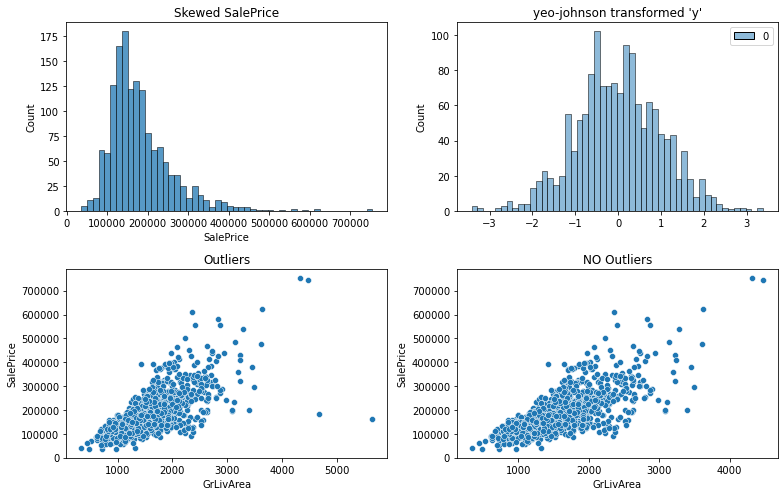

In [107]:
# taking cara of some outliers
# and making more gausian 'y'
d_tr = analyze_y(d_tr.copy())

In [108]:
# after take care of some outlier
# combine the training and the test
all_d = combine_tr_te(d_tr.copy(), d_te.copy(), verbose=True)
all_d.shape

New data shape:  (2917, 80)


(2917, 80)

In [109]:
# imputing nan
all_d = impute_nan(all_d.copy())

In [110]:
all_d.columns[all_d.isna().any()].to_list()

['SalePrice']

In [111]:
# reducing the number of categories in some columns
all_d = reduce_categories(all_d.copy())
# all_d['Foundation'].value_counts()

PConc     1306
CBlock    1235
BrkTil     311
Others      65
Name: Foundation, dtype: int64

### Feature Engineering

In [118]:
# creating new columns like cluster ...
all_d = features_engineering(all_d.copy())

### Categorical and Number Columns

In [123]:
# getting the global variables
ord_cat_mapping, ord_cat_DONE, cat_to_1Hot = get_global_variables()

In [125]:
# updating the data type
all_d = all_d.astype(cat_to_1Hot)
all_d = all_d.astype(ord_cat_DONE)

In [127]:
# getting the number columns
numbers_col = all_d.select_dtypes('number')
numbers_col = numbers_col.columns.to_list()

In [129]:
analyzed_col = numbers_col + list(cat_to_1Hot.keys()) + list(ord_cat_DONE.keys())
set( all_d.columns.to_list() ) - set( analyzed_col )

{'Training'}

In [132]:
set( analyzed_col ) - set( all_d.columns.to_list() )

set()

In [131]:
print('analyzed_col len:', len(analyzed_col))
print('all_d.columns len', len(all_d.columns.to_list()))

analyzed_col len: 83
all_d.columns len 84


### Doing Ordinal and OneHot Encoding

In [146]:
# encoding ordinal and onehot columns
all_d = ordinal_1hot_encode(all_d.copy(), ord_cat_mapping, cat_to_1Hot)

In [ ]:
all_d.columns.to_list()

### Working on Number Columns

> Skew Col

In [152]:
skewed = all_d[numbers_col].skew()
len(skewed)

33

In [156]:
skewed = skewed[skewed >= 0.7]
skewed = skewed.index
len(skewed)

22

In [154]:
fix_data_skew = Pipeline([('scaler', RobustScaler()), 
                          ('yeo', PowerTransformer(method='yeo-johnson'))])

In [165]:
# fixing the skew data
# all_d2 = all_d.copy()
all_d[skewed] = fix_data_skew.fit_transform(all_d[skewed].copy())

> Feature Selection

In [166]:
d_tr = all_d[ all_d['Training']].copy()

In [169]:
y = d_tr['SalePrice'].copy()
d_tr.drop(columns=['SalePrice'], inplace=True)

In [170]:
mutual_infi = mutual_info_regression(X = d_tr, y= y)

In [173]:
temp = pd.DataFrame( list(zip(d_tr.columns, mutual_infi)), columns=['Features', 'Mutual Info'] )
temp = temp.sort_values('Mutual Info', ascending=False)
# temp[temp['Mutual Info'] == 0 ].head(20)

,Features,Mutual Info
156,TotalSF,0.683218
29,OverallQual,0.581919
90,GrLivArea,0.476245
108,GarageCars,0.375766
109,GarageArea,0.369454
80,TotalBsmtSF,0.365371
31,YearBuilt,0.361197
66,ExterQual,0.341624
72,BsmtQual,0.335442
97,KitchenQual,0.328671


In [178]:
temp[ abs( temp['Mutual Info']) == 0 ].shape#.sort_values('Features')

(24, 2)

In [208]:
d_tr = all_d[ all_d['Training']].copy()
mutual_info = mutual_info_regression(X = d_tr.drop(columns='SalePrice'), y=d_tr['SalePrice'].copy())

In [209]:
mu_df = pd.DataFrame(list(zip( d_tr.columns, mutual_info )), columns=['Feature', 'Mutual_info'])
mu_df.shape

(167, 2)

In [217]:
f_to_drop = mu_df[ mu_df['Mutual_info'] == 0]
f_to_drop = list( f_to_drop['Feature'] )
f_to_drop

['MSZoning_3',
 'MSZoning_5',
 'LotConfig_3',
 'Condition1_1',
 'Condition1_2',
 'RoofMatl_1',
 'Exterior1st_5',
 'Exterior1st_10',
 'Exterior1st_11',
 'Exterior2nd_3',
 'Exterior2nd_4',
 'Exterior2nd_7',
 'Exterior2nd_8',
 'Exterior2nd_12',
 'MasVnrType_4',
 'Foundation_4',
 'BsmtFinSF2',
 'Heating_2',
 'MiscFeature_2',
 'MoSold_5',
 'MoSold_8',
 'MoSold_9',
 'MoSold_12',
 'YrSold_3',
 'YrSold_5',
 'SalePrice',
 'PeakMonths_2',
 'Neighborhood_Cluster_1',
 'MSSubClass_Cluster_1']

In [226]:
to_drop = feature_selection(d_tr.drop(columns='SalePrice').copy(), d_tr['SalePrice'].copy(), verbose=True)
to_drop

29 Features with Zero(0) mutual info: 

['BsmtFinSF2', 'Condition1_3', 'Condition2_2', 'Exterior1st_11', 'Exterior1st_8', 'Exterior2nd_3', 'Exterior2nd_8', 'Finished_2', 'Heating_1', 'LotConfig_2', 'LowQualFinSF', 'MSSubClass_Cluster_5', 'MSZoning_5', 'MiscFeature_1', 'MiscFeature_2', 'MiscVal', 'MoSold_11', 'MoSold_12', 'MoSold_4', 'MoSold_5', 'MoSold_8', 'MoSold_9', 'Neighborhood_Cluster_2', 'PoolArea', 'RoofMatl_2', 'RoofStyle_3', 'SaleType_4', 'Training', 'YrSold_1']


['MSZoning_5',
 'LotConfig_2',
 'Condition1_3',
 'Condition2_2',
 'RoofStyle_3',
 'RoofMatl_2',
 'Exterior1st_8',
 'Exterior1st_11',
 'Exterior2nd_3',
 'Exterior2nd_8',
 'BsmtFinSF2',
 'Heating_1',
 'LowQualFinSF',
 'PoolArea',
 'MiscFeature_1',
 'MiscFeature_2',
 'MiscVal',
 'MoSold_4',
 'MoSold_5',
 'MoSold_8',
 'MoSold_9',
 'MoSold_11',
 'MoSold_12',
 'YrSold_1',
 'SaleType_4',
 'Training',
 'Finished_2',
 'Neighborhood_Cluster_2',
 'MSSubClass_Cluster_5']

In [225]:
def feature_selection(X, y, verbose=False):
    
    mutual_info = mutual_info_regression(X=X, y=y)
    
    mu_info_df = pd.DataFrame(list(zip( X.columns, mutual_info )), columns=['Features', 'Mutual_info'])
    
    feature_to_dop = mu_info_df[ mu_info_df['Mutual_info'] == 0]
    feature_to_dop = list( feature_to_dop['Features'] )
    
    if(verbose):
        #Sorting
        # mu_info_df.sort_values('Mutual_info', ascending=False, inplace=True)
        print('{} Features with Zero(0) mutual info: \n'.format(len(feature_to_dop)))
        print(sorted(feature_to_dop))
    
    return feature_to_dop
    